<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg" />
</center> 
     
## <center>  [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

#### <center> Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko) 

## <center> A disciplined approach to cross-validation in a Kaggle (Inclass) competition 


Here we'll show how to progress with feature engineering in the [Alice](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) competition, we'll simulate some mistakes that can be done, show how to interpret model weights with [eli5](https://github.com/TeamHG-Memex/eli5), and discuss our validation scheme even further. Prerequisites: [Alice - logistic regression baseline](https://www.kaggle.com/kashnitsky/alice-logistic-regression-baseline) and [Correct time-aware cross-validation scheme](https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme).
 
 
Plan:
 - [Submission 1: "Bag of sites" baseline](#Submission-1:-"Bag-of-sites"-baseline)
 - [Submission 2: Coming up with time features via EDA](#Submission-2:-Coming-up-with-time-features-via-EDA)
 - [Submission 3: Example of overfitting](#Submission-3:-Example-of-overfitting)
 - [Submissions 4 and 5: The importance of feature scaling](#Submissions-4-and-5:-The-importance-of-feature-scaling)
 - [Submission 6: Adding more time features](#Submission-6:-Adding-more-time-features)
 - [Submission-7: Tuning-params](#Submission-7:-Tuning-params)
 - [Analyzing submission history](#Analyzing-submission-history)
 - [Conclusions](#Conclusions)

In [1]:
# Import libraries and set desired options
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack
# !pip install eli5
import eli5
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display_html

In [2]:
PATH_TO_DATA = '../../data/'
SEED = 17

## Submission 1: "Bag of sites" baseline

**We'll start with basic site features, applying the "bag of words" approach. Here we read training and test sets, sort train set by session start time.**

In [3]:
# Helper functions

# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

def get_domain(url):
    splitted = url.split('.')
    if len(splitted) == 1:
        return splitted[0]
    else:
        return splitted[-2] + '.' + splitted[-1]

In [4]:
def prepare_sparse_features(path_to_train, path_to_test, path_to_site_dict,
                           vectorizer_params, include_domain_features=False):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train,
                       index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test,
                      index_col='session_id', parse_dates=times)

    # Sort the data by time
    train_df = train_df.sort_values(by='time1')
    
    # read site -> id mapping provided by competition organizers 
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create an inverse id _> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # we treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # Transform data into format which can be fed into TfidfVectorizer
    # This time we prefer to represent sessions with site names, not site ids. 
    # It's less efficient but thus it'll be more convenient to interpret model weights.
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    # we'll tell TfidfVectorizer that we'd like to split data by whitespaces only 
    # so that it doesn't split by dots (we wouldn't like to have 'mail.google.com' 
    # to be split into 'mail', 'google' and 'com')
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    site_and_domain_feature_names = vectorizer.get_feature_names()
    
    if include_domain_features:
        train_sessions_domains = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                         ' '.join([get_domain(id2site[i]) for i in row]), axis=1).tolist()
        test_sessions_domains = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                         ' '.join([get_domain(id2site[i]) for i in row]), axis=1).tolist()
        # we'll tell TfidfVectorizer that we'd like to split data by whitespaces only 
        # so that it doesn't split by dots (we wouldn't like to have 'mail.google.com' 
        # to be split into 'mail', 'google' and 'com')
        vectorizer_domains = TfidfVectorizer(**vectorizer_params)
        X_train_domains = vectorizer_domains.fit_transform(train_sessions_domains)
        X_test_domains = vectorizer_domains.transform(test_sessions_domains)
        
        X_train = hstack([X_train, X_train_domains])
        X_test = hstack([X_test, X_test_domains])
        site_and_domain_feature_names = site_and_domain_feature_names + vectorizer_domains.get_feature_names()
    
    y_train = train_df['target'].astype('int').values
    # we'll need site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, site_and_domain_feature_names, train_times, test_times

**By running the above function, we get sparse train and test matrices (`X_train_sites`, `X_test_sites`), vector of train targets `y_train` (0's and 1's - whether a session belongs to Alice or not), an instance of `TfidfVectorizer` (we'll need site name from it) and site visit times both for training and test sets, for further feature engineering. Go back to the function defined above, read comments, and experiment yourself to understand what we've done here.**

In [ ]:
%%time
X_train_sites, X_test_sites, y_train, vectorizer_sites, site_and_domain_feature_names, train_times, test_times = prepare_sparse_features(
    path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={'ngram_range': (1, 5), 
                       'max_features': 50000,
                       'tokenizer': lambda s: s.split()},
    include_domain_features=False
)

In [ ]:
print(X_train_sites.shape, X_test_sites.shape)

**We'll be performing time series cross-validation, see [the previous kernel](https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme) for an explanation.**

In [ ]:
time_split = TimeSeriesSplit(n_splits=3)

**Perform time series cross-validation with logistic regression.**

In [ ]:
logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear')

**We are going to repeat these steps several more times. It's a nice practice to substitute repeated chunks of code with function calls. So let's write a function which performs cross-validation, model training, displaying feature importance, making predictions for a test set and forming a submission file.**

In [ ]:
def train_and_predict(model, X_train, y_train, X_test, site_feature_names=site_and_domain_feature_names, 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=-1)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names 
    else: 
        all_feature_names = site_feature_names
    
    display_html(eli5.show_weights(estimator=model, 
                  feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
    
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

In [ ]:
cv_scores1 = train_and_predict(model=logit, X_train=X_train_sites, y_train=y_train, 
                  X_test=X_test_sites, site_feature_names=site_and_domain_feature_names,              
                  cv=time_split, submission_file_name='subm1.csv')

## Submission 2: Coming up with time features via EDA
Here we'll build just a few plots to motivate feature engineering. While competing, you'll need to create much more plots and build more features based on your observations. Take a look at [Kernels](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/kernels?sortBy=voteCount&group=everyone&pageSize=20&competitionId=7173) for this competition, eg. at [this "Initial EDA"](https://www.kaggle.com/adityaecdrid/initial-eda). You can do much more with sites, but let's switch to site visit times.

We've got an intuition: different people might prefer to visit (even the same) sites at *different* times of the day. Let's first draw the distribution of all session start hours. 

In [16]:
session_start_hour = train_times['time1'].apply(lambda ts: ts.hour).values

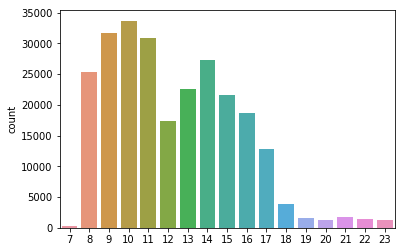

In [17]:
sns.countplot(session_start_hour);

Now the same separately for Alice and everybody else.

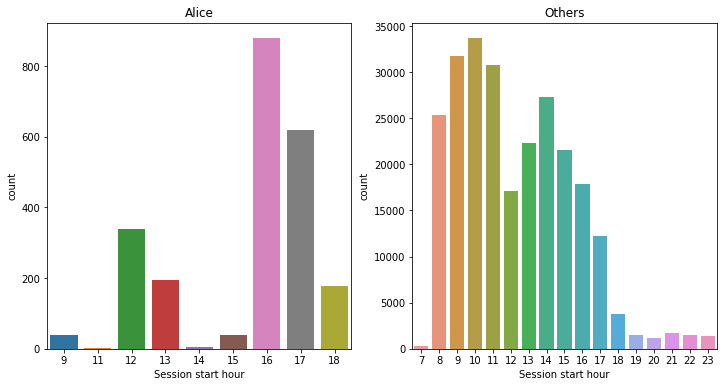

In [18]:
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(session_start_hour[y_train == 1])
plt.title("Alice")
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.countplot(session_start_hour[y_train == 0])
plt.title('Others')
plt.xlabel('Session start hour');

Now we definitely see that Alice mostly prefers 4-5 pm for browsing. So let's create features 'morning', 'day' and 'evening' and 'night'. Separators between these times of the day will be almost arbitrary: 0 am, 7 am, 12 am, and 7 pm. However, you can tune this.

In [19]:
morning = ((session_start_hour >= 7) & (session_start_hour <= 11)).astype('int')
day = ((session_start_hour >= 12) & (session_start_hour <= 18)).astype('int')
evening = ((session_start_hour >= 19) & (session_start_hour <= 23)).astype('int')
night = ((session_start_hour >= 0) & (session_start_hour <= 6)).astype('int')

In [20]:
pd.crosstab([morning, day, evening, night], y_train, rownames=['morning', 'day', 'evening', 'night'])

col_0                           0     1
morning day evening night              
0       0   1       0        7251     0
        1   0       0      122129  2256
1       0   0       0      121884    41

**Let's create a separate function to add new features (this will keep the code cleaner). To demonstrate possible overfitting, we'll keep a flag - whether to add an `hour` feature or not.**

In [53]:
def add_time_features(times, X_sparse, add_hour=True):
    hour = times['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1, 1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1, 1)
    night = ((hour >= 0) & (hour <=6)).astype('int').values.reshape(-1, 1)
    
    max_hour = times.max(axis=1).apply(lambda ts: ts.hour)
    max_morning = ((max_hour >= 7) & (max_hour <= 11)).astype('int').values.reshape(-1, 1)
    max_day = ((max_hour >= 12) & (max_hour <= 18)).astype('int').values.reshape(-1, 1)
    max_evening = ((max_hour >= 19) & (max_hour <= 23)).astype('int').values.reshape(-1, 1)
    max_night = ((max_hour >= 0) & (max_hour <=6)).astype('int').values.reshape(-1, 1)
    
    objects_to_hstack = [X_sparse, morning, day, evening, night, max_morning, max_day, max_evening, max_night]
    feature_names = ['morning', 'day', 'evening', 'night', 'max_morning', 'max_day', 'max_evening', 'max_night']
    
    if add_hour:
        # we'll do it right and scale hour dividing by 24
        objects_to_hstack.append(hour.values.reshape(-1, 1) / 24)
        feature_names.append('hour')
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [54]:
%%time
X_train_with_times1, new_feat_names = add_time_features(train_times, X_train_sites)
X_test_with_times1, _ = add_time_features(test_times, X_test_sites)

Wall time: 3.05 s


In [55]:
X_train_with_times1.shape, X_test_with_times1.shape

((253561, 50009), (82797, 50009))

**Performing time series cross-validation, we see an improvement in ROC AUC.**

In [56]:
cv_scores2 = train_and_predict(model=logit, X_train=X_train_with_times1, y_train=y_train, 
                               X_test=X_test_with_times1, 
                               site_feature_names=site_and_domain_feature_names,
                               new_feature_names=new_feat_names,
                               cv=time_split, submission_file_name='subm2.csv')

CV scores [0.88116858 0.95598258 0.9455347 ]
CV mean: 0.9275619531676277, CV std: 0.03308119590169001


Weight?,Feature
+7.177,hour
+5.148,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.990,www.express.co.uk
+4.829,youwatch.org
+4.809,www.info-jeunes.net
+4.686,vk.com
+4.578,www.melty.fr
+4.327,fr.glee.wikia.com
+4.104,www.audienceinsights.net
+3.960,www.banque-chalus.fr


New feature weights:
       feature      coef
0      morning -1.865503
1          day -1.608852
2      evening -3.533190
3        night  0.000000
4  max_morning -2.728751
5      max_day -0.672188
6  max_evening -3.606605
7    max_night  0.000000
8         hour  7.176985


**We see an improvement almost for all folds as compared to the results of previous cross-validation.**

In [57]:
cv_scores2 > cv_scores1

array([ True,  True,  True])

## Submission 3: Example of overfitting

**Making a new submission, we notice a leaderboard score improvement as well (0.91807 ->  0.93089). Looks good as compared to sites only. But we might be a bit wary that feature `hour` gets such a big weight. Let's try the same features but without `hour`.**

In [58]:
%%time
X_train_with_times2, new_feat_names = add_time_features(train_times, X_train_sites, add_hour=False)
X_test_with_times2, _ = add_time_features(test_times, X_test_sites, add_hour=False)


cv_scores3 = train_and_predict(model=logit, X_train=X_train_with_times2, y_train=y_train, 
                               X_test=X_test_with_times2, 
                               site_feature_names=site_and_domain_feature_names,
                               new_feature_names=new_feat_names,
                               cv=time_split, submission_file_name='subm3.csv')

CV scores [0.87716629 0.94672457 0.93871997]
CV mean: 0.9208702761110853, CV std: 0.03107568238889277


Weight?,Feature
+5.220,youwatch.org
+5.094,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.972,www.express.co.uk
+4.919,vk.com
+4.642,fr.glee.wikia.com
+4.539,www.info-jeunes.net
+4.388,www.melty.fr
+4.186,www.audienceinsights.net
+4.106,www.banque-chalus.fr
+3.827,r4---sn-gxo5uxg-jqbe.googlevideo.com


New feature weights:
       feature      coef
0      morning -1.812521
1          day -0.600391
2      evening -1.989996
3        night  0.000000
4  max_morning -2.469165
5      max_day  0.120856
6  max_evening -2.054598
7    max_night  0.000000
Wall time: 10.2 s


**Now cross-validation is much more stable. 3rd CV results are better for each and every fold as compared to the first ones. And actually the situation is better than with the `hour` feature for 5 folds out of 10, but in such case we'll prefer a model with less variation of CV results, i.e. the last one.**

In [59]:
cv_scores3 > cv_scores1

array([ True,  True,  True])

In [60]:
cv_scores3 > cv_scores2

array([False, False, False])

Making a new submission we get... Wow! **0.94535** Public LB score instead of **0.93089** when adding the `hour` feature. We were right, the `hour` feature leads to overfitting, and it's better not to add it. 

## Submissions 4 and 5: The importance of feature scaling

**Now we'll add a new feature: session duration. But beware: first we'll do it in an incorrect way, then we'll correct ourselves.**

In [61]:
def add_session_duration_incorrect(times, X_sparse):
    new_feat = (times.max(axis=1) - times.min(axis=1)).astype('timedelta64[ms]').astype(int)
    return hstack([X_sparse, new_feat.values.reshape(-1, 1)])

In [62]:
X_train_with_time_incorrect = add_session_duration_incorrect(train_times, X_train_with_times2)
X_test_with_time_incorrect = add_session_duration_incorrect(test_times, X_test_with_times2)

In [63]:
cv_scores4 = train_and_predict(model=logit, X_train=X_train_with_time_incorrect, y_train=y_train, 
                               X_test=X_test_with_time_incorrect, 
                               site_feature_names=site_and_domain_feature_names,
                               new_feature_names=new_feat_names + ['sess_duration'],
                               cv=time_split, submission_file_name='subm4.csv')

CV scores [0.57164005 0.66517354 0.65713194]
CV mean: 0.6313151728192128, CV std: 0.042324203481602304


y=1
 
 

top features
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 
 … 1816 more positive … 
 
 
 

 
 
 
 … 48162 more negative … 
 
 
 
 
 
 
 -0.008
 
 
 www.youtube.com
 
 
 
 
 
 
 -0.009
 
 
 mail.google.com
 
 
 
 
 
 
 -0.010
 
 
 clients1.google.com
 
 
 
 
 
 
 -0.010
 
 
 mts1.google.com
 
 
 
 
 
 
 -0.010
 
 
 ajax.googleapis.com
 
 
 
 
 
 
 -0.010
 
 
 twitter.com
 
 
 
 
 
 
 -0.010
 
 
 mts0.google.com
 
 
 
 
 
 
 -0.012
 
 
 accounts.google.com
 
 
 
 
 
 
 -0.013
 
 
 ts1.mm.bing.net
 
 
 
 
 
 
 -0.013
 
 
 connect.facebook.net
 
 
 
 
 
 
 -0.016
 
 
 www.google.fr
 
 
 
 
 
 
 -0.018
 
 
 s-static.ak.facebook.com
 
 
 
 
 
 
 -0.019
 
 
 static.ak.facebook.com
 
 
 
 
 
 
 -0.020
 
 
 www.bing.com
 
 
 
 
 
 
 -0.021
 
 
 apis.google.com
 
 
 
 
 
 
 -0.021
 
 
 www.google.com
 
 
 
 
 
 
 -0.022
 
 
 platform.twitter.com
 
 
 
 
 
 
 -0.031
 
 
 www.facebook.com
 
 
 
 
 
 
 -0.037
 
 
 unknown unknown unknown unknown unknown
 
 
 
 
 
 
 -0.042
 
 
 evening
 
 
 
 
 
 
 -0.042
 
 
 max_evening
 
 
 
 
 
 
 -0.046
 
 
 unknown unknown unknown unknown
 
 
 
 
 
 
 -0.054
 
 
 unknown unknown unknown
 
 
 
 
 
 
 -0.063
 
 
 unknown unknown
 
 
 
 
 
 
 -0.071
 
 
 unknown
 
 
 
 
 
 
 -0.505
 
 
 max_day
 
 
 
 
 
 
 -0.505
 
 
 day
 
 
 
 
 
 
 -0.576
 
 
 morning
 
 
 
 
 
 
 -0.576
 
 
 max_morning
 
 
 
 
 
 
 -1.123
 
 
 <BIAS>

New feature weights:
         feature      coef
0        morning -0.576343
1            day -0.505015
2        evening -0.042120
3          night  0.000000
4    max_morning -0.576349
5        max_day -0.504998
6    max_evening -0.042131
7      max_night  0.000000
8  sess_duration -0.000037


**What's the reason of such a deterioration?**
Obvious! The new feature is session duration in milliseconds, it's maximal value is very high (check it). We need to either scale a new feature or, alternatively, measure it in some different units. You can check that actually, measuring it in seconds (rather than milliseconds will do). But instead we'll perform feature scaling, it's a more universal technique to apply for numeric features which can take high values.

In [64]:
train_durations = (train_times.max(axis=1) - train_times.min(axis=1)).astype('timedelta64[ms]').astype(int)
test_durations = (test_times.max(axis=1) - test_times.min(axis=1)).astype('timedelta64[ms]').astype(int)

scaler = StandardScaler()
train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1, 1))
test_dur_scaled = scaler.transform(test_durations.values.reshape(-1, 1))

C:\Users\sepolt\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\sepolt\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\sepolt\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [65]:
X_train_with_time_correct = hstack([X_train_with_times2, train_dur_scaled])
X_test_with_time_correct = hstack([X_test_with_times2, test_dur_scaled])

In [66]:
cv_scores5 = train_and_predict(model=logit, X_train=X_train_with_time_correct, y_train=y_train, 
                               X_test=X_test_with_time_correct, 
                               site_feature_names=site_and_domain_feature_names,
                               new_feature_names=new_feat_names + ['sess_duration'],
                               cv=time_split, submission_file_name='subm5.csv')

CV scores [0.87804885 0.94785141 0.93974312]
CV mean: 0.921881125952956, CV std: 0.031170366827151717


Weight?,Feature
+5.213,youwatch.org
+5.057,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.979,vk.com
+4.965,www.express.co.uk
+4.618,fr.glee.wikia.com
+4.528,www.info-jeunes.net
+4.367,www.melty.fr
+4.150,www.banque-chalus.fr
+4.149,www.audienceinsights.net
+3.793,r4---sn-gxo5uxg-jqbe.googlevideo.com


New feature weights:
         feature      coef
0        morning -1.743001
1            day -0.682652
2        evening -2.005481
3          night  0.000000
4    max_morning -2.565621
5        max_day  0.176371
6    max_evening -2.041883
7      max_night  0.000000
8  sess_duration -0.243718


**New model predicts better on 9 folds out of 10 as compared to the model with sites and time features. Submitting yields 0.94630 Public LB ROC AUC.**

In [67]:
cv_scores5 > cv_scores3

array([ True,  True,  True])

## Submission 6: Adding more time features

In a real competition it's very important to keep track of Public Kernels and borrow some ideas form them.  For instance, we can explore [this Kernel](https://www.kaggle.com/hakeydotcom/additional-time-features-and-logit) and decide to add to features: day of week and month. In this case it's easy to come up to such features on your own, but still typically there's a lot to find out in Kernels.  

In [68]:
def add_day_month(times, X_sparse):
    day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    # linear trend: time in a form YYYYMM, we'll divide by 1e5 to scale this feature 
    year_month = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
    
    objects_to_hstack = [X_sparse, day_of_week, month, year_month]
    feature_names = ['day_of_week', 'month', 'year_month']
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [69]:
X_train_final, more_feat_names = add_day_month(train_times, X_train_with_time_correct)
X_test_final, _ = add_day_month(test_times, X_test_with_time_correct)

In [70]:
cv_scores6 = train_and_predict(model=logit, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=site_and_domain_feature_names,
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split, submission_file_name='subm6.csv')

CV scores [0.87567281 0.94481945 0.94960089]
CV mean: 0.9233643835268014, CV std: 0.03377947973446146


Weight?,Feature
+5.161,youwatch.org
+5.046,vk.com
+5.008,www.express.co.uk
+4.983,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.682,www.info-jeunes.net
+4.446,www.melty.fr
+4.386,fr.glee.wikia.com
+4.334,www.audienceinsights.net
+4.020,www.banque-chalus.fr
+3.959,api.bing.com


New feature weights:
          feature      coef
0         morning -0.597191
1             day  0.491826
2         evening -1.181066
3           night  0.000000
4     max_morning -1.381191
5         max_day  1.305632
6     max_evening -1.210873
7       max_night  0.000000
8   sess_duration -0.264265
9     day_of_week -0.367816
10          month  0.108546
11     year_month -2.649156


## Submission 7: Tuning params
When you're done with feature engineering (no more ideas) you can tune hyperparameters in your model. Typically, at this point you create nice code for your pipeline, and then tune various params for a long time. Here we used several params - `ngram_range`, `max_features`. Choosing between `CountVectorizer` and `TfIdfVectorizer` might also be treated as a hyperparameter. But now we'll tune only regularization strength `C`.

In [ ]:
# here we've already narrowed down c_values to such a range.
# typically, you would start with a wider range of values to check
c_values = np.logspace(-2, 2, 20)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [ ]:
%%time
logit_grid_searcher.fit(X_train_final, y_train); 

In [ ]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

In [ ]:
final_model = logit_grid_searcher.best_estimator_

In [ ]:
cv_scores7 = train_and_predict(model=final_model, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=site_and_domain_feature_names,
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split, submission_file_name='subm7.csv')

Here tuning params helps only for 6 folds out of 10. Typically in such situation you'll make one more submission to compare LB scores as well. 0.94954 - it's less than without hyperparameter tuning. **Bad news in the end:** our CV scheme is not perfect. Try  to improve it! (*hint:* is all training set needed for a good prediction?). 

In [ ]:
cv_scores7 > cv_scores6

## Analyzing submission history
Let's summarize CV results and LB scores for all 7 submissions:

In [73]:
cv_means = [np.round(cv_scores.mean(), 5) for cv_scores in [cv_scores1, cv_scores2, cv_scores3,
                                                                 cv_scores4, cv_scores5, cv_scores6, ]]
cv_stds = [np.round(cv_scores.std(), 5) for cv_scores in [cv_scores1, cv_scores2, cv_scores3,
                                                                 cv_scores4, cv_scores5, cv_scores6, ]]
public_lb_scores = [0.91807, 0.93135, 0.94526, 0.67016, 0.94620, 0.95070]

subm_df = pd.DataFrame({'CV_mean': cv_means, 'CV_std': cv_stds, 'LB': public_lb_scores},
                      index=range(1, len(cv_means) + 1))
subm_df

,CV_mean,CV_std,LB
1,0.85603,0.04762,0.91807
2,0.92756,0.03308,0.93135
3,0.92087,0.03108,0.94526
4,0.63132,0.04232,0.67016
5,0.92188,0.03117,0.94620
6,0.92336,0.03378,0.95070


The correlation between CV mean and LB exists, but it's not perfect. So which submission to choose in the end? A popular method is to treat mean CV and LB results with weights, proportional to train and test sizes. However, considering time, we'll trust public LB score more and set it's weight to 0.6 (no theory here, only practical experience). Also, as we've seen, standard deviation of CV results is also important, so you can experiment here. 

In [ ]:
subm_df['cv_lb_weighted'] =  0.6 * subm_df['LB'] + (1 - 0.6) * subm_df['CV_mean']
subm_df

In [ ]:
# so we'll treat the last submission as the best one
!cp subm7.csv submission.csv

## Conclusions
 - keep track of cross-validation improvements for *each* fold (or at least as many folds as possible)
 - take a look at cross-validation std, not only mean
 - try to build a CV scheme so that CV improvements correlate with LB improvements (it's very important)
 - exploring feature importance might help, sometimes even in detecting overfitting
 - spend most of the competition time exploring data and building features
 
Good luck!

<img src="https://habrastorage.org/webt/ai/xu/sy/aixusyqysuiou9rsll7x909jyw0.jpeg" width=50% /> 
*<div style="text-align: center"> image credit <a href='http://www.alicekristiansen.com/'>www.alicekristiansen.com</a> </div>*
